Домашнее задание №4.

Применение бертоподобных моделей к задаче классификации

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе, используя пайплайн с Trainer от HuggingFace.


1. обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

2. измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

3. примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

*4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

5. выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла

Общие требования: (1 балл) Для всех моделей используйте одинаковые гиперпараметры, чтобы их результаты можно было сравнить между собой.

Комментируйте ваши решения в коде.

Для каждой из моделей нужно привести результаты на тестовой выборке.

Вы можете использовать любую предобученную модель, которая подходит для работы с английским, кроме bert-base-cased

# 1. Модель, которую мы разбирали на занятии



Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [1]:
!pip install -q -U watermark

In [2]:
!pip install transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 67.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 104MB/s]


In [5]:
import transformers
from transformers import BertModel, DistilBertModel, AutoTokenizer, BertTokenizer, DistilBertTokenizerFast, AdamW, get_linear_schedule_with_warmup, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch.nn.functional as F

import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [7]:
df = pd.read_csv("reviews.csv")

In [8]:
df = df[:6000]  # чтоб быстрее было
df.shape

(6000, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              6000 non-null   object
 1   userImage             6000 non-null   object
 2   content               6000 non-null   object
 3   score                 6000 non-null   int64 
 4   thumbsUpCount         6000 non-null   int64 
 5   reviewCreatedVersion  5026 non-null   object
 6   at                    6000 non-null   object
 7   replyContent          3121 non-null   object
 8   repliedAt             3121 non-null   object
 9   sortOrder             6000 non-null   object
 10  appId                 6000 non-null   object
dtypes: int64(2), object(9)
memory usage: 515.8+ KB


In [10]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [11]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

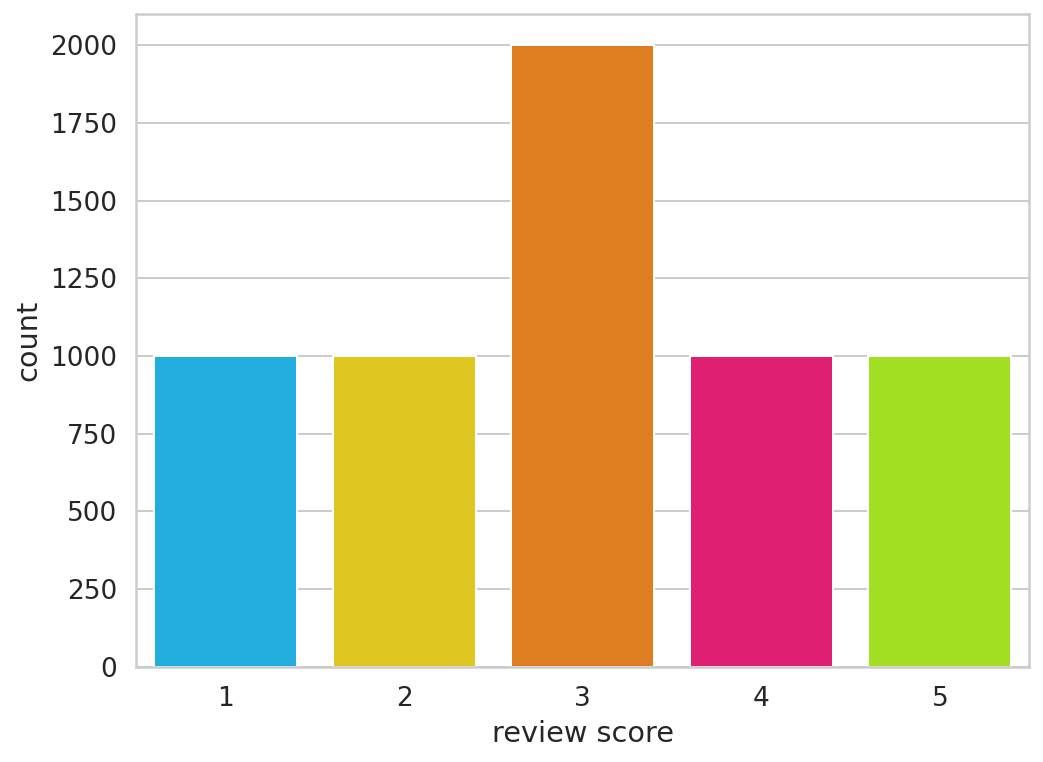

In [12]:
sns.countplot(df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [13]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [14]:
class_names = ['negative', 'neutral', 'positive']

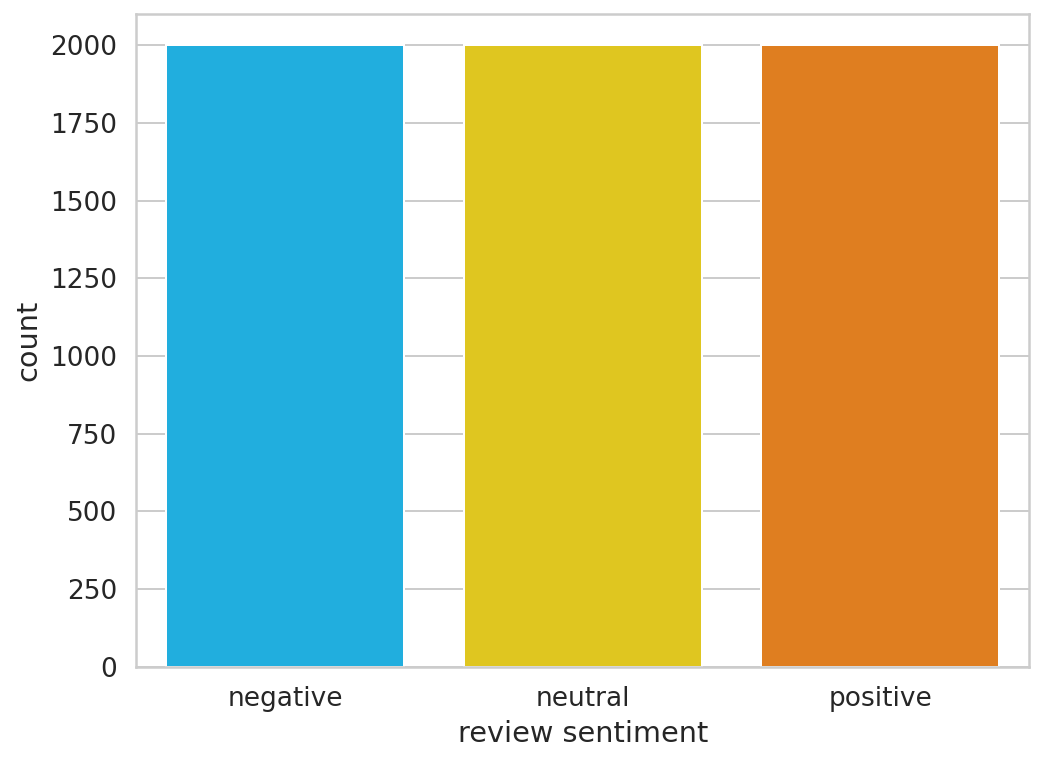

In [15]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Предобработка данных

In [16]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda', index=0)

In [18]:
# Делим данные на обучающую, тестовую и валидационную выборки
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
train_texts = list(df_train["content"])
train_labels = list(df_train["sentiment"])
test_texts = list(df_test["content"])
test_labels = list(df_test["sentiment"])
val_texts = list(df_val["content"])
val_labels = list(df_val["sentiment"])

In [19]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)
max_len = 160  # максимальная длина последовательности

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_len)

In [21]:
# Dataset, который на каждой итерации будет возвращать токенизированный отзыв и класс

class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPReviewDataset(train_encodings, train_labels)
val_dataset = GPReviewDataset(val_encodings, val_labels)
test_dataset = GPReviewDataset(test_encodings, test_labels)

In [22]:
# метрики
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [23]:
# параметры обучения
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

## Классификация сентимента

In [24]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.n_classes = n_classes
        self.out = nn.Linear(self.bert.config.hidden_size*4, n_classes)
  
    def forward(self, input_ids, attention_mask, labels=None):
        last_hidden_state, hidden_states = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=False)
        cls_tokens = []
        for hidden_state in hidden_states[-4:]:
            cls_tokens.append(hidden_state[:, 0, : ])
        pooled_output = torch.cat(cls_tokens, 1)  # пришлось написать
        output = self.drop(pooled_output)
        logits = self.out(output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
        return loss, logits

In [25]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
# model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
device

device(type='cuda', index=0)

In [27]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

***** Running training *****
  Num examples = 5400
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


Step,Training Loss
10,1.160100
20,1.183800
30,1.201500
40,1.121500
50,1.176100
60,1.076300
70,1.130200
80,1.091700
90,1.094200
100,1.130500


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1350, training_loss=0.7102192163467407, metrics={'train_runtime': 372.6203, 'train_samples_per_second': 28.984, 'train_steps_per_second': 3.623, 'total_flos': 0.0, 'train_loss': 0.7102192163467407, 'epoch': 2.0})

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.8        0.71559633 0.81218274]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.90243902 0.67826087 0.77669903]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7184466  0.75728155 0.85106383]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_accuracy': 0.7733333333333333,
 'eval_f1': array([0.8       , 0.71559633, 0.81218274]),
 'eval_loss': 0.6019710302352905,
 'eval_precision': array([0.90243902, 0.67826087, 0.77669903]),
 'eval_recall': array([0.7184466 , 0.75728155, 0.85106383]),
 'eval_runtime': 2.9721,
 'eval_samples_per_second': 100.938,
 'eval_steps_per_second': 6.393}

In [29]:
# Оценим модель на тестовых данных
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.85087719 0.75       0.87777778]" of type <class 'numpy.ndarray'> for key "test/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.88181818 0.70588235 0.89772727]" of type <class 'numpy.ndarray'> for key "test/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8220339  0.8        0.85869565]" of type <class 'numpy.ndarray'> for key "test/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'test_accuracy': 0.8266666666666667,
 'test_f1': array([0.85087719, 0.75      , 0.87777778]),
 'test_loss': 0.4994933009147644,
 'test_precision': array([0.88181818, 0.70588235, 0.89772727]),
 'test_recall': array([0.8220339 , 0.8       , 0.85869565]),
 'test_runtime': 2.998,
 'test_samples_per_second': 100.068,
 'test_steps_per_second': 6.338}

# 2. Модель с cls токенами вместе с выходами пуллер слоя

In [30]:
class SentimentClassifier2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.n_classes = n_classes
        self.out = nn.Linear(self.bert.config.hidden_size*5, n_classes)
  
    def forward(self, input_ids, attention_mask, labels=None):
        last_hidden_state, hidden_states = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=False)
        cls_tokens = []
        for hidden_state in hidden_states[-4:]:
            cls_tokens.append(hidden_state[:, 0, : ])
        pooled_output = torch.cat(cls_tokens, 1)
        new_output = torch.cat((pooled_output, last_hidden_state[:, 0, : ]), 1) # добавили
        print(new_output.shape)
        output = self.drop(new_output)
        logits = self.out(output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
        return loss, logits

In [31]:
model2 = SentimentClassifier2(len(class_names))
model2 = model2.to(device)
# model2

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [32]:
trainer = Trainer(
    model=model2,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

***** Running training *****
  Num examples = 5400
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


torch.Size([8, 3840])


Step,Training Loss
10,1.099300
20,1.147400
30,1.120800
40,1.093500
50,1.124600
60,1.100600
70,1.078900
80,1.112800
90,1.062700
100,1.130300


torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size

Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size

Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size([8, 3840])
torch.Size



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1350, training_loss=0.7056574784384834, metrics={'train_runtime': 370.9712, 'train_samples_per_second': 29.113, 'train_steps_per_second': 3.639, 'total_flos': 0.0, 'train_loss': 0.7056574784384834, 'epoch': 2.0})

In [33]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


torch.Size([16, 3840])


torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([12, 3840])


Trainer is attempting to log a value of "[0.76190476 0.67281106 0.78350515]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8372093  0.64035088 0.76      ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.69902913 0.70873786 0.80851064]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_accuracy': 0.7366666666666667,
 'eval_f1': array([0.76190476, 0.67281106, 0.78350515]),
 'eval_loss': 0.6645860075950623,
 'eval_precision': array([0.8372093 , 0.64035088, 0.76      ]),
 'eval_recall': array([0.69902913, 0.70873786, 0.80851064]),
 'eval_runtime': 2.9814,
 'eval_samples_per_second': 100.623,
 'eval_steps_per_second': 6.373}

In [34]:
# Оценим модель на тестовых данных
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


torch.Size([16, 3840])


torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([16, 3840])
torch.Size([12, 3840])


Trainer is attempting to log a value of "[0.84070796 0.76142132 0.88135593]" of type <class 'numpy.ndarray'> for key "test/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.87962963 0.70093458 0.91764706]" of type <class 'numpy.ndarray'> for key "test/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.80508475 0.83333333 0.84782609]" of type <class 'numpy.ndarray'> for key "test/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'test_accuracy': 0.8266666666666667,
 'test_f1': array([0.84070796, 0.76142132, 0.88135593]),
 'test_loss': 0.4969889223575592,
 'test_precision': array([0.87962963, 0.70093458, 0.91764706]),
 'test_recall': array([0.80508475, 0.83333333, 0.84782609]),
 'test_runtime': 2.9904,
 'test_samples_per_second': 100.322,
 'test_steps_per_second': 6.354}

# 3. Готовая модель для классификации последовательности

In [35]:
from transformers import DistilBertConfig
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = 3
model3 = DistilBertForSequenceClassification(config)
model3 = model3.to(device)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}



In [36]:
trainer = Trainer(
    model=model3,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

***** Running training *****
  Num examples = 5400
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


Step,Training Loss
10,1.116300
20,1.143700
30,1.085500
40,1.140200
50,1.166900
60,1.096900
70,1.107600
80,1.101300
90,1.081200
100,1.161500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1350, training_loss=0.9084115173198559, metrics={'train_runtime': 371.8599, 'train_samples_per_second': 29.043, 'train_steps_per_second': 3.63, 'total_flos': 447085443456000.0, 'train_loss': 0.9084115173198559, 'epoch': 2.0})

In [37]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.65979381 0.55454545 0.72043011]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7032967  0.52136752 0.72826087]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.62135922 0.59223301 0.71276596]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_accuracy': 0.64,
 'eval_f1': array([0.65979381, 0.55454545, 0.72043011]),
 'eval_loss': 0.8411106467247009,
 'eval_precision': array([0.7032967 , 0.52136752, 0.72826087]),
 'eval_recall': array([0.62135922, 0.59223301, 0.71276596]),
 'eval_runtime': 2.9867,
 'eval_samples_per_second': 100.446,
 'eval_steps_per_second': 6.362}

In [38]:
# Оценим модель на тестовых данных
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.72       0.55555556 0.76836158]" of type <class 'numpy.ndarray'> for key "test/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.75700935 0.50925926 0.8       ]" of type <class 'numpy.ndarray'> for key "test/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.68644068 0.61111111 0.73913043]" of type <class 'numpy.ndarray'> for key "test/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'test_accuracy': 0.68,
 'test_f1': array([0.72      , 0.55555556, 0.76836158]),
 'test_loss': 0.7112144231796265,
 'test_precision': array([0.75700935, 0.50925926, 0.8       ]),
 'test_recall': array([0.68644068, 0.61111111, 0.73913043]),
 'test_runtime': 3.0008,
 'test_samples_per_second': 99.973,
 'test_steps_per_second': 6.332}

# 4. Агрегируем cls-токены для нескольких слоев, чтобы сделать предсказание класса 

In [39]:
class SentimentClassifier4(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.n_classes = n_classes
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask, labels=None):
        last_hidden_state, hidden_states = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=False)
        cls_tokens = []
        for hidden_state in hidden_states[-4:]:
            cls_tokens.append(hidden_state[:, 0, : ])
        cls_output = torch.stack(cls_tokens, 1)
        average_cls_output = torch.mean(cls_output, 1)  # вот тут
        output = self.drop(average_cls_output)
        logits = self.out(output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
        return loss, logits

In [40]:
model4 = SentimentClassifier4(len(class_names))
model4 = model4.to(device)
# model

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [41]:
trainer = Trainer(
    model=model4,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

***** Running training *****
  Num examples = 5400
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


Step,Training Loss
10,1.180700
20,1.133400
30,1.148700
40,1.113300
50,1.141600
60,1.122500
70,1.122100
80,1.086200
90,1.067200
100,1.105600


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1350, training_loss=0.7146344621093185, metrics={'train_runtime': 370.2466, 'train_samples_per_second': 29.17, 'train_steps_per_second': 3.646, 'total_flos': 0.0, 'train_loss': 0.7146344621093185, 'epoch': 2.0})

In [42]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.78074866 0.69683258 0.80208333]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.86904762 0.65254237 0.78571429]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.70873786 0.74757282 0.81914894]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'eval_accuracy': 0.7566666666666667,
 'eval_f1': array([0.78074866, 0.69683258, 0.80208333]),
 'eval_loss': 0.6496446132659912,
 'eval_precision': array([0.86904762, 0.65254237, 0.78571429]),
 'eval_recall': array([0.70873786, 0.74757282, 0.81914894]),
 'eval_runtime': 2.9889,
 'eval_samples_per_second': 100.37,
 'eval_steps_per_second': 6.357}

In [43]:
# Оценим модель на тестовых данных
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


Trainer is attempting to log a value of "[0.84581498 0.7253886  0.85555556]" of type <class 'numpy.ndarray'> for key "test/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.88073394 0.67961165 0.875     ]" of type <class 'numpy.ndarray'> for key "test/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.81355932 0.77777778 0.83695652]" of type <class 'numpy.ndarray'> for key "test/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 2.0,
 'test_accuracy': 0.81,
 'test_f1': array([0.84581498, 0.7253886 , 0.85555556]),
 'test_loss': 0.5105229020118713,
 'test_precision': array([0.88073394, 0.67961165, 0.875     ]),
 'test_recall': array([0.81355932, 0.77777778, 0.83695652]),
 'test_runtime': 2.9943,
 'test_samples_per_second': 100.19,
 'test_steps_per_second': 6.345}

# 5. Предсказание класса отзыва с google play

In [44]:
review_texts = ["App is awkward. And even worse, convert to pdf from Chrome makes a pdf with the page url. Not the actual web page. Pointless.",
                "You application tends to be non responsive buffering to too long. I keep crossing and reopening it to use.",
                "I have been using acrobat from Adobe since 2007 now I use it on my phone as well as my laptop or computer. It's great software for everything a home office needs to get the job done right."]
true_labels = [0, 1, 2]
labels_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
# 1, 3, 5 звёзд

In [45]:
reviews_encodings = tokenizer(review_texts, truncation=True,
                                 padding=True, max_length=max_len)
dataset_to_predict = GPReviewDataset(reviews_encodings, true_labels)

predictions = trainer.predict(dataset_to_predict)
preds = np.argmax(predictions.predictions, axis=-1)
for i in range(len(preds)):
    print(f'Review text: {review_texts[i]}')
    print(f'Sentiment  : {labels_dict[preds[i]]}')
    print(f'True sentiment  : {labels_dict[true_labels[i]]}')

***** Running Prediction *****
  Num examples = 3
  Batch size = 16


Review text: App is awkward. And even worse, convert to pdf from Chrome makes a pdf with the page url. Not the actual web page. Pointless.
Sentiment  : negative
True sentiment  : negative
Review text: You application tends to be non responsive buffering to too long. I keep crossing and reopening it to use.
Sentiment  : neutral
True sentiment  : neutral
Review text: I have been using acrobat from Adobe since 2007 now I use it on my phone as well as my laptop or computer. It's great software for everything a home office needs to get the job done right.
Sentiment  : positive
True sentiment  : positive
